In [67]:
"""
Calculates the n32 bias for general estimators.
"""

import bispectrum_3D_numba as b3n

import interpolated_quantities_numba as iqn

import numba as nb

import temperatureinfo as ti

import numpy as np

import vegas

from lenscarf import n0n1_iterative as n01

import matplotlib.pyplot as plt

from scipy import interpolate

In [146]:
############ SETTINGS   #####################

ptt_key = "ptt"
pee_key = "p_p"

qe_key = "ptt"
itermax = 3

cls_unl = np.load("cls_unl.npy", allow_pickle = True).take(0)
cls_len = np.load("cls_len.npy", allow_pickle = True).take(0)
cls_grad = np.load("cls_grad.npy", allow_pickle = True).take(0)
fidcls_noise = np.load("fidcls_noise.npy", allow_pickle = True).take(0)

print("Setting bb noise to inf")
fidcls_noise["bb"] += 1e23
#cls_len["bb"] *= 0
#cls_unl["eb"] *= 0#
#cls_grad["eb"] *= 0

print("Info")

s4 = True

if qe_key == "ptt":
    if s4:
        noise, beam = 1., 1.
    else:
        noise, beam = 7., 1.4
else:
    noise, beam = 1., 1.*np.sqrt(2)

if s4:
    lmin, lmax = 10, 4000 
else:
    lmin, lmax = 40, 3000 
print("lmin, lmax", lmin, lmax)
print("noise, beam", noise, beam)

uTT, lTT, tTT, gTT = ti.get_interpolated(lmin, lmax, noise, beam) #QE quantities, 0 iteration


print("lmin, lmax", lmin, lmax)
uEE, lEE, tEE, gEE = ti.get_interpolatedEE(lmin, lmax, noise, beam)

lBB, gBB, tBB = ti.get_interpolatedBB(lmin, lmax, noise, beam)

Ls = np.arange(10, 500, 50)
Ls = np.concatenate((Ls, np.arange(500, 4500, 180)))

print("Calculate results at Ls", Ls, "len", len(Ls))

print("Preparing some results with lenscarf")

try:
#    result = np.load("result.npy", allow_pickle = True).take(0)
    N0s_biased = np.load(f"N0s_biased_{qe_key}.npy", allow_pickle = True)
    N0s_unbiased = np.load(f"N0s_unbiased_{qe_key}.npy", allow_pickle = True)
    delcls_fid = np.load(f"delcls_fid_{qe_key}.npy", allow_pickle = True)
    delcls_true = np.load(f"delcls_true_{qe_key}.npy", allow_pickle = True)
    N1s_biased = np.load(f"N1s_biased_{qe_key}.npy", allow_pickle = True)
    N1s_unbiased = np.load(f"N1s_unbiased_{qe_key}.npy", allow_pickle = True)

except:
    result = n01.get_biases_iter(qe_key, nlev_t = 1, nlev_p = 1*np.sqrt(2), beam_fwhm = 1., cls_unl_fid = cls_unl, lmin_ivf = lmin, lmax_ivf = lmax, itermax = itermax, datnoise_cls = fidcls_noise,
                                lmax_qlm=None, version = 'wN1')
    Rs, N0s_biased, N0s_unbiased, delcls_fid, delcls_true, N1s_biased, N1s_unbiased = result
    np.save(f"N0s_biased_{qe_key}.npy", N0s_biased)
    np.save(f"N0s_unbiased_{qe_key}.npy", N0s_unbiased)
    np.save(f"delcls_fid_{qe_key}.npy", delcls_fid)
    np.save(f"delcls_true_{qe_key}.npy", delcls_true)
    np.save(f"N1s_biased_{qe_key}.npy", N1s_biased)
    np.save(f"N1s_unbiased_{qe_key}.npy", N1s_unbiased)
    np.save(f"Rs_{qe_key}.npy", Rs)


pps = [d["pp"] for d in delcls_fid]

gradients = []


def get_camb():
    import camb
    from camb import model
    #Use flat sky, get gradient spectra
    #pars =camb.set_params(H0=None, cosmomc_theta =0.010411,lmax=4200, lens_potential_accuracy=1)
    lmax = 8000
    pars = camb.CAMBparams()
    #print pars.Recomb.RECFAST_fudge

    pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.1212, mnu=0)
    pars.InitPower.set_params(As=2.1265e-09, ns=0.96)

    # reionization and recombination 
    pars.Reion.use_optical_depth = True
    pars.Reion.optical_depth = 0.0925
    pars.Reion.delta_redshift = 0.5
    pars.Recomb.RECFAST_fudge = 1.14

    # accuracy
    pars.set_for_lmax(lmax+200, lens_potential_accuracy=4)

    #non linearity
    pars.NonLinear = model.NonLinear_both
    pars.NonLinearModel.halofit_version = 'takahashi'
    pars.Accuracy.AccurateBB = True #need this to avoid small-scale ringing
    #config.lensing_method=lensing_method_curv_corr
    #%time data1=camb.get_results(pars)
    #config.lensing_method=lensing_method_flat_corr # default

    pars.max_l = lmax

    return camb.get_results(pars)

try:
    gradients = np.load(f"gradients_{qe_key}.npy", allow_pickle = True)
except:
    data = get_camb()
    for i, clpp in enumerate(pps):
        ls = np.arange(0, len(clpp))
        clpp = clpp*(ls*(ls+1))**2./2/np.pi
        caso = data.get_lensed_gradient_cls(lmax = len(clpp), CMB_unit = 'muK', raw_cl = True, clpp = clpp)
        TT, EE, BB = caso.T[:3]
        if qe_key == "ptt":
            g = TT
        elif qe_key == pee_key:
            g = EE
        else:
            print("Estimator not implemented")

        gradients += [g]

    np.save(f"gradients_{qe_key}.npy", gradients)



if False:
    for i, p in enumerate(pps):
        plt.loglog(p, label = "delcl_fid %d"%i)
    plt.legend()
    plt.show()

Setting bb noise to inf
Info
lmin, lmax 10 4000
noise, beam 1.0 1.0
lmin, lmax 10 4000
Calculate results at Ls [  10   60  110  160  210  260  310  360  410  460  500  680  860 1040
 1220 1400 1580 1760 1940 2120 2300 2480 2660 2840 3020 3200 3380 3560
 3740 3920 4100 4280 4460] len 33
Preparing some results with lenscarf


In [147]:
import sympy as sp

p1, p2 = sp.symbols('p1 p2')
expr = sp.sin(2*(p1-p2))
expr = sp.expand_trig(expr)
l1, l2, l1x, l1y, l2x, l2y = sp.symbols('l1 l2 l1x l1y l2x l2y')

expr = sp.expand(sp.simplify(expr.subs([(sp.cos(p1),l1x/l1),(sp.cos(p2),l2x/l2),
                            (sp.sin(p1),l1y/l1),(sp.sin(p2),l2y/l2)])))

lmbdasin = sp.lambdify((l1, l2, l1x, l1y, l2x, l2y), expr, "numpy")

expr = sp.cos(2*(p1-p2))
expr = sp.expand_trig(expr)
expr = sp.expand(sp.simplify(expr.subs([(sp.cos(p1),l1x/l1),(sp.cos(p2),l2x/l2),
                            (sp.sin(p1),l1y/l1),(sp.sin(p2),l2y/l2)])))
lmbdacos = sp.lambdify((l1, l2, l1x, l1y, l2x, l2y), expr, "numpy")


def dotbatch(a, b):
    return a[0, :]*b[0, :]+a[1, :]*b[1, :]

def fgradEEbatch(l1v, l2v, l1n, l2n, gradientEE):
    Lv = l1v+l2v
    #calculate cos of double the angle between l1v and l2v
    factor = lmbdacos(l1n, l2n, l1v[0, :], l1v[1, :], l2v[0, :], l2v[1, :])
    #there should be ClPPper too. ignoring it.
    return (dotbatch(Lv, l1v)*gradientEE(l1n)+dotbatch(Lv, l2v)*gradientEE(l2n))*factor

def fgradEBbatch(l1v, l2v, l1n, l2n, gradientEE, gradientBB):
    Lv = l1v+l2v
    #calculate sin of double the angle between l1v and l2v
    factor = lmbdasin(l1n, l2n, l1v[0, :], l1v[1, :], l2v[0, :], l2v[1, :])
    return dotbatch(Lv, l1v)*gradientEE(l1n)+dotbatch(Lv, l2v)*gradientBB(l2n)*factor

def funlTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*uTT(l1n)+dotbatch(Lv, l2v)*uTT(l2n)

def flenTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*lTT(l1n)+dotbatch(Lv, l2v)*lTT(l2n)

def fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*gradientTT(l1n)+dotbatch(Lv, l2v)*gradientTT(l2n)

def ftotTTfTTbatch(l):
    return tTT(l)

def ftotEEfEEbatch(l):
    return tEE(l)

def ftotBBfBBbatch(l):
    return tBB(l)

def gfEEbatch(lv, Lv, l1n, l2n, gradientEE, totalEE = ftotEEfEEbatch):
    l1v, l2v = lv, Lv-lv
    return fgradEEbatch(l1v, l2v, l1n, l2n, gradientEE)/(2*totalEE(l1n)*totalEE(l2n))

def gfEBbatch(lv, Lv, l1n, l2n, gradientEE, gradientBB, totalEE = ftotEEfEEbatch, totalBB = ftotBBfBBbatch):
    l1v, l2v = lv, Lv-lv
    return fgradEBbatch(l1v, l2v, l1n, l2n, gradientEE, gradientBB)/(2*totalEE(l1n)*totalBB(l2n))

def gfTTbatch(lv, Lv, l1n, l2n, gradientTT, totalTT = ftotTTfTTbatch):
    l1v, l2v = lv, Lv-lv
    return fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT)/(2*totalTT(l1n)*totalTT(l2n))

def gfTTbatch_for_modes(l1v, l2v, l1n, l2n, gradientTT, totalTT = ftotTTfTTbatch):
    return fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT)/(2*totalTT(l1n)*totalTT(l2n))

filter_batch = lambda x: (x >= lmin) & (x <= lmax)


In [148]:
################# CALCULATIONS #####################

def get_AL_MC(Ls, est = "ptt", gradientfunction = None, total = None):

    integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
    nitn, neval = 1e2, 1e3

    ALMC = []

    for LL in Ls:
        @vegas.batchintegrand
        def integrand(x):
            l1, theta1 = x.T
            l1v = np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
            L = np.ones_like(l1)*LL
            Lv = np.c_[L, np.zeros_like(l1)].T
            l3v = Lv-l1v

            l3 = np.linalg.norm(l3v, axis = 0)

            if est == "ptt":
                gradientTT, totalTT = gradientfunction, total
                fXY = fgradTTbatch(l1v, l3v, l1, l3, gradientTT)
                gXY = gfTTbatch_for_modes(l1v, l3v, l1, l3, gradientTT, totalTT)*filter_batch(l3)
            elif est == "p_p":
                gradientEE, totalEE = gradientfunction, total
                fXY = fgradEEbatch(l1v, l3v, l1, l3, gradientEE)
                gXY = gfEEbatch(l1v, Lv, l1, l3, gradientEE, totalEE)*filter_batch(l3)
            else:
                print("Estimator not implemented")

            product = fXY*gXY     
            common = l1/(2*np.pi)**2

            return product*common
        
        result = integ(integrand, nitn = nitn, neval = neval)
        ALMC += [result.mean]

    ALMC = np.array(ALMC)**-1.

    return ALMC


In [149]:
ALMCS = []

ALMCSextended = []
Lsextended = np.arange(1, 4500, 10)

for i in range(itermax):

    print("Iteration %d"%i)

    current_gradient = gradients[i]
    ls = np.arange(0, len(current_gradient))

    gradientf = interpolate.interp1d(ls, current_gradient, fill_value = 0., bounds_error = False)

    noise_component = ti.get_noise(ls, noise, beam)
    
    if qe_key == "ptt":
        cmbpartial = delcls_true[i]["tt"]
    elif qe_key == "p_p":
        cmbpartial = delcls_true[i]["ee"]
    else:
        print("Estimator not implemented")

    lmaxcomm = min(len(ls), len(cmbpartial))

    total = cmbpartial[:lmaxcomm]+noise_component[:lmaxcomm]
    ls = ls[:lmaxcomm]
    totalf = interpolate.interp1d(ls, total, fill_value = 1e10, bounds_error = False)

    ALMC = get_AL_MC(Ls, est = qe_key, gradientfunction = gradientf, total = totalf)
    ALMCS += [ALMC]

    ALMCextended = get_AL_MC(Lsextended, est = qe_key, gradientfunction = gradientf, total = totalf)
    ALMCSextended += [ALMCextended]

Iteration 0
Iteration 1
Iteration 2


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_19758/1850291477.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  plt.loglog(Rs[i]**-1., color = f"C{i}", ls = "--")


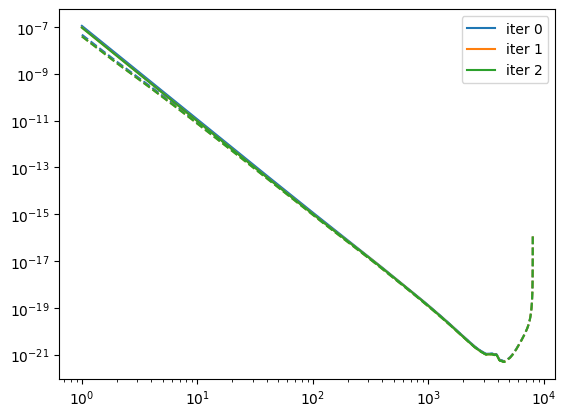

In [150]:
Rs = np.load("Rs_ptt.npy", allow_pickle = True)
for i, A in enumerate(ALMCSextended):
    plt.plot(Lsextended, A, label = "iter %d"%i, color = f"C{i}")
    plt.loglog(Rs[i]**-1., color = f"C{i}", ls = "--")


plt.legend()
plt.show()

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_19758/3882614594.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(Rs[i]**-1./Rs[0]**-1., color = p[0].get_color(), ls = '--', alpha = 0.4)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_19758/3882614594.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(Rs[i]**-1./Rs[0]**-1., color = p[0].get_color(), ls = '--', alpha = 0.4)


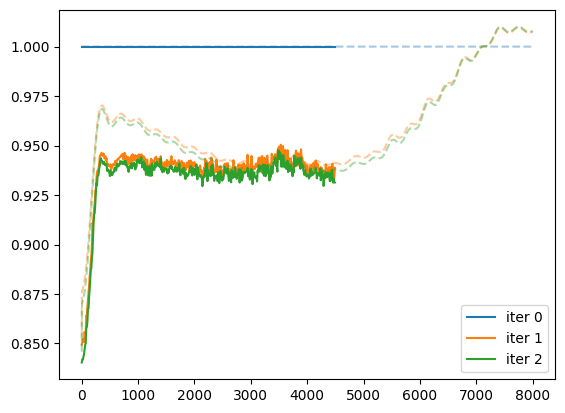

In [151]:
for i, A in enumerate(ALMCSextended):
    p = plt.plot(Lsextended, A/ALMCSextended[0], label = "iter %d"%i)
    plt.plot(Rs[i]**-1./Rs[0]**-1., color = p[0].get_color(), ls = '--', alpha = 0.4)
plt.legend()
plt.show()

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_19758/3647248957.py:5: RuntimeWarning: invalid value encountered in divide
  W = cpp/(cpp+Af(lW))
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_19758/3647248957.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  Af = interpolate.interp1d(ll, Rs[it]**-1., fill_value = 0., bounds_error = False)
/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


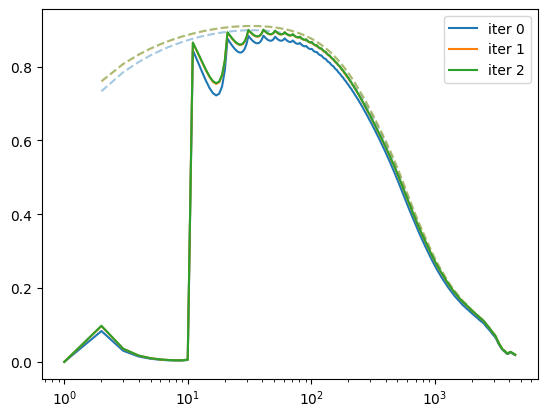

In [152]:
for it in range(itermax):
    lW = np.arange(0, Lsextended.max())
    Af = interpolate.interp1d(Lsextended, ALMCSextended[it], fill_value = 0., bounds_error = False, kind = "linear") 
    cpp = pps[0][:len(lW)]
    W = cpp/(cpp+Af(lW))
    np.savetxt(f"W_{qe_key}_{it}.txt", W)
    p = plt.plot(lW, W, label = "iter %d"%it)

    ll = np.arange(0, len(Rs[0]))
    Af = interpolate.interp1d(ll, Rs[it]**-1., fill_value = 0., bounds_error = False) 
    cpp = pps[0][:len(lW)]
    W = cpp/(cpp+Af(lW))
    plt.plot(lW, W, color = p[0].get_color(), ls = '--', alpha = 0.4)

plt.xscale("log")
plt.legend()


In [153]:
n32 = {}

integ = vegas.Integrator([[lmin, lmax], [lmin, lmax], [0, 2*np.pi], [0, 2*np.pi]], nhcube_batch = 2000)
nitn, neval = 4e1, 1e3

for it in range(itermax):

    print("Iteration %d"%it)

    current_gradient = gradients[it]
    ls = np.arange(0, len(current_gradient))

    gradientf = interpolate.interp1d(ls, current_gradient, fill_value = 0., bounds_error = False)

    noise_component = ti.get_noise(ls, noise*(1+it == 1), beam*(1+it == 1))
    
    if qe_key == "ptt":
        cmbpartial = delcls_true[it]["tt"]
    elif qe_key == "p_p":
        cmbpartial = delcls_true[it]["ee"]
    else:
        print("Estimator not implemented")

    lmaxcomm = min(len(ls), len(cmbpartial))

    total = cmbpartial[:lmaxcomm]+noise_component[:lmaxcomm]
    ls = ls[:lmaxcomm]
    totalf = interpolate.interp1d(ls, total, fill_value = 1e10, bounds_error = False)

    if it > 0:
        W = np.loadtxt(f"W_{qe_key}_{it-1}.txt")
        lW = np.arange(0, len(W))
        Wsinterp = interpolate.interp1d(lW, W, fill_value = 0., bounds_error = False)

    #model = "SC"
    bpmodel = "GM"
    models = [bpmodel]#, "SC", "GM"]#, "SC", "GM"]#, "SC"]#, "SC", "GM"]
    indices = {"TR": 0, "SC": 1, "GM": 2}
    #index = models.index(model)

    results_n32 = {}

    for model in models:

        index = indices[model]

        print("Working on model", model, ", index", index)

        keys = ["B", "PB"]
        NTOT = {k: [] for k in keys}

        for LL in Ls:
            @vegas.batchintegrand
            def integrand(x):
                l1, l2, theta1, theta2 = x.T
                cos1, cos2 = np.cos(theta1), np.cos(theta2)
                sin1, sin2 = np.sin(theta1), np.sin(theta2)

                l1v = np.array([l1*cos1, l1*sin1])
                l2v = np.array([l2*cos2, l2*sin2])

                l5v = l1v-l2v

                L = np.ones_like(l1)*LL
                Lv = np.c_[L, np.zeros_like(l1)].T

                l4v = Lv-l2v
                
                l5 = np.sqrt((l1*cos1-l2*cos2)**2+(l1*sin1-l2*sin2)**2)
                l4 = np.sqrt(LL**2+l2**2-2*LL*l2*cos2)
                l3 = np.sqrt(LL**2+l1**2-2*LL*l1*cos1)

                l4_dot_L = (-LL*l2*cos2 + LL**2)
                l2_dot_L = (LL*l2*cos2)

                #gXY = gfEEbatch(l2v, Lv, l2, l4, gradientf, totalf)*filter_batch(l4)
                #gYX = gfEEbatch(l4v, Lv, l4, l2, gradientf, totalf)*filter_batch(l4)

                gXY = gfTTbatch(l2v, Lv, l2, l4, gradientf, totalf)*filter_batch(l4)
                gYX = gXY


                l1_dot_l2 = (l1*cos1*l2*cos2) + (l1*sin1*l2*sin2)
                l2_dot_l3 = l2_dot_L-l1_dot_l2
                l5_dot_l1 = l1**2-l1_dot_l2
                l5_dot_l3 = LL*l1*cos1-l2_dot_L-l1**2+l1_dot_l2

                #cl5_XY = uEE(l5)*filter_batch(l5) #uTT(l5)*filter_batch(l5)
                #Cl2 = uEE(l2) #uTT(l2)
                cl5_XY = gradientf(l5)*filter_batch(l5)
                Cl2 = gradientf(l2)

                if qe_key == "ptt":
                    hX_l5_l2 = 1.
                    hY_l5_l4 = 1.
                    hY_l2_l4 = 1.
                    hX_l2_l4 = 1.
                else:
                    hX_l5_l2 = lmbdacos(l5, l2, l5v[0, :], l5v[1, :], l2v[0, :], l2v[1, :])
                    hY_l5_l4 = lmbdacos(l5, l4, l5v[0, :], l5v[1, :], l4v[0, :], l4v[1, :])

                    hY_l2_l4 = lmbdacos(l2, l4, l2v[0, :], l2v[1, :], l4v[0, :], l4v[1, :])
                    hX_l2_l4 = lmbdacos(l2, l4, l2v[0, :], l2v[1, :], l4v[0, :], l4v[1, :])


                factor1 = 1. if it == 0 else (1-np.nan_to_num(Wsinterp(l1))) #np.nan_to_num((1-Wsinterp(l1))*(1-Wsinterp(l3)))
                #factor3 = 1. if it == 0 else (1-np.nan_to_num(Wsinterp(l3))) #np.nan_to_num((1-Wsinterp(l1))*(1-Wsinterp(l3)))

                productA1 = -l5_dot_l1*l5_dot_l3*hX_l5_l2*hY_l5_l4*cl5_XY*gXY*factor1# if it == 0 else 0.
                #productA1 = 0.
                productC1 = l2_dot_l3*l1_dot_l2*(gXY*hY_l2_l4+gYX*hX_l2_l4*factor1)*Cl2*1/2

                if it > 0:
                    normanew = np.sqrt(l2**2+l3**2-2*l2_dot_l3)
                    Ctotnew = totalf(normanew)
                    Ctot2 = totalf(l2)
                    productnew = -Cl2**2./Ctot2/Ctotnew*(l2_dot_L)*(l1_dot_l2)*(l2_dot_l3)*filter_batch(normanew)*factor1
                else:
                    productnew = 0.



                #born_term = bispectrum_Born(l1, l3, LL)*8/(l1*l3*LL)**2
                born_term = 0.

                #ff = 1+(1-Wsinterpiter1(l1))*(1-Wsinterpiter1(l3))
                #factor = np.nan_to_num((1-Wsinterp(l1))*(1-Wsinterp(l3))) #(1-Wsinterp(l1))*(1-Wsinterp(l3))
                
                #factor = 1. if it == 0 else np.nan_to_num(Wsinterp(l1)) #np.nan_to_num((1-Wsinterp(l1))*(1-Wsinterp(l3)))
                factor = 1.
                bispectrum_result = b3n.bispec_phi_general(l1, l3, LL, index)*factor #*(1+(1-rho2interp1(l1))*(1-rho2interp1(l3)))

                bispectrum_total = bispectrum_result+born_term

                common = l1*l2*bispectrum_result/(2*np.pi)**4
                common_total = l1*l2*bispectrum_total/(2*np.pi)**4

                #A1 = common*productA1
                #C1 = common*productC1
                result = (productA1+productC1+productnew)*common
                result_total = (productA1+productC1+productnew)*common_total
                #return [common*productA1, common*productC1]
                return {"B": result, "PB": result_total} #{'A1': common*productA1, 'C1': common*productC1}
            
            result = integ(integrand, nitn = 2*nitn, neval = 2*neval)
            for k in keys:
                NTOT[k] += [result[k].mean]
            
            #NA1 += [result['A1'].mean]
            #NC1 += [result['C1'].mean]
        for k in keys:
            NTOT[k] = np.array(NTOT[k])
        results_n32[model] = NTOT
    
    n32[it] = results_n32

Iteration 0
Working on model GM , index 2
Iteration 1
Working on model GM , index 2
Iteration 2
Working on model GM , index 2


In [154]:
llplot = np.arange(20, 3500, 20)

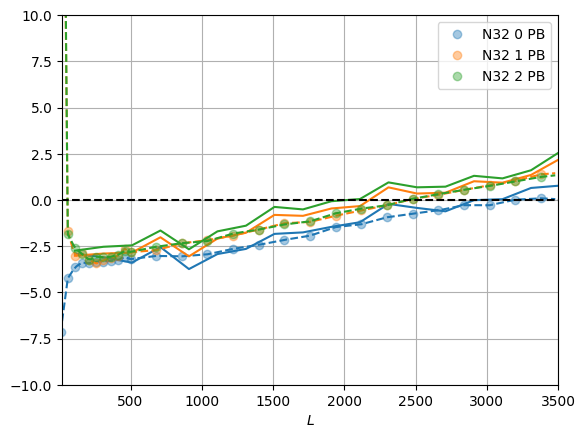

In [155]:
terms = ["PB"] #, "B"]
ppinterp = np.interp(Ls, ti.l, ti.pp)

somma = 0.
vector = 0.

Ws = []

for ii in range(2):
    W = np.loadtxt(f"W_{qe_key}_{ii}.txt")
    lW, W = np.loadtxt(f"W{ii}.txt").T
    W = np.nan_to_num(W)
    lW = np.arange(0, len(W))
    Wsinterp = interpolate.interp1d(lW, W, fill_value = 0., bounds_error = False)
    Ws += [Wsinterp]

#for ii in range(1):
#    plt.plot(lW, Ws[ii](lW)/Ws[ii+1](lW), label = ii)
#plt.legend()
#plt.show()

for ii, NTOT in n32.items():

    fac = ALMCS[ii]

    #fac = 1/Rfunl(Ls) #*R_unl(Ls)

    for term in terms:
        vector = (NTOT[bpmodel][term])/ppinterp*100
        if ii > 0:
            vector *= 1.#Ws[ii-1](Ls)
            #vector += vector
            #vector *= ALMCS[ii]
            #vector *= Wsinterp(Ls)
        #elif ii == 0:
        #    vector /= Ws[ii+1](Ls)
    
        vector *= fac
        vectorf = interpolate.interp1d(Ls, vector, fill_value = 0., bounds_error = False)
        interpolated = vectorf(llplot)
        p = plt.plot(Ls, vector, label = f'N32 {ii} {term}', alpha = 0.4, ls = "", marker = "o")
        plt.plot(llplot, interpolated, color = p[0].get_color(), ls = "--")
        #plt.plot(Ls, somma*rginvinterp, label = f'N32 {ii} {term}', alpha = 0.4, ls = "", marker = "o")
        np.savetxt(f"n32_{qe_key}_{ii}_{term}_{bpmodel}.txt", np.c_[llplot, interpolated])

        #vector *= (Ws(Ls) if ii == 0 else 1.)

        data = np.loadtxt(f"/Users/omard/Documents/projects/n32plots/data/tt/binned_tt_n32_cross_born_{ii}.txt")
        elbin, valuebase = data[:, 0], data[:, 1]
        plt.plot(elbin, valuebase*100, color = p[0].get_color())
        
plt.plot(Ls, np.zeros_like(Ls), ls = '--', color = 'black')

plt.legend()
plt.xlabel(r"$L$")
plt.xlim(20, 3500)
#plt.ylim(-1.5, 1.5)
plt.ylim(-10, 10)

plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


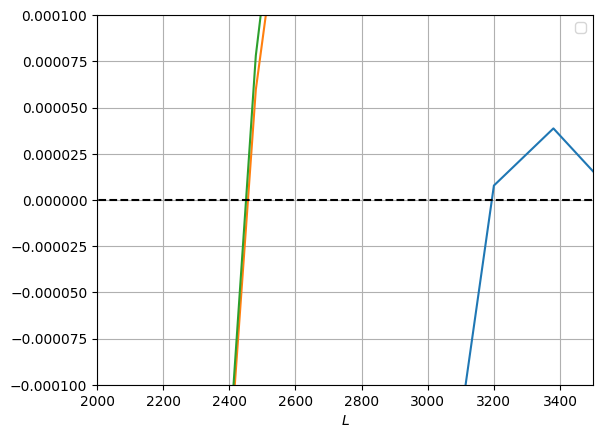

In [156]:
terms = ["PB"] #, "B"]
ppinterp = np.interp(Ls, ti.l, ti.pp)

somma = 0.
vector = 0.

a = [1, 1]

for ii, NTOT in n32.items():

    for term in terms:
        fac = ALMCS[ii]
        facA = (Ws[ii](Ls) if ii == 0 else 1.)
        #facB = (Rfunl(Ls)**-1. if ii > 0 else 1.)
        vector = (NTOT[bpmodel][term])#*facA*fac/ppinterp  #*a[ii] #*(Wsinterp(Ls) if ii == 0 else 1.)#*(Wss[ii](Ls) if ii == 0 else 1.) #*Wss[ii](Ls) if ii < 1 else 1. #*Wss[ii](Ls)
        plt.plot(Ls, vector)
        
plt.plot(Ls, np.zeros_like(Ls), ls = '--', color = 'black')

plt.legend()
plt.xlabel(r"$L$")
plt.xlim(2000, 3500)
plt.ylim(-1e-4, 1e-4)
plt.grid()

In [108]:
labels = {}
labels["ptt"] = "TT"
labels["p_p"] = "EE"

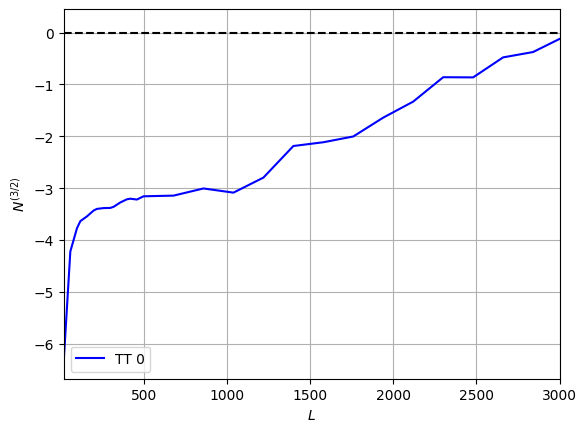

In [15]:
term = "PB"

for qe_key_ in ["ptt"]:
    for ii in range(1):
        llplot, interpolated = np.loadtxt(f"n32_{qe_key_}_{ii}_{term}.txt", unpack = True)
        plt.plot(llplot, interpolated, label = f"{labels[qe_key_]} {ii}", color = "blue")

plt.plot(llplot, np.zeros_like(llplot), ls = '--', color = 'black')

plt.legend()
plt.xlabel(r"$L$")
plt.ylabel(r"$N^{(3/2)}$")
plt.xlim(20, 3000)
#plt.ylim(-1.5, 1.5)
plt.grid()

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_19758/3609959055.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(R/R_unl)


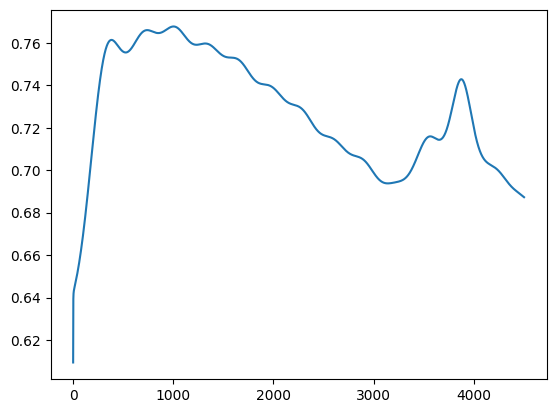

In [15]:
R = np.loadtxt("R.txt")
R_unl = np.loadtxt("R_unl.txt")
lR = np.arange(0, len(R))

Rf = interpolate.interp1d(lR, R, fill_value = 0., bounds_error = False)
Rfunl = interpolate.interp1d(lR, R_unl, fill_value = 0., bounds_error = False)

plt.plot(R/R_unl)